<a href="https://colab.research.google.com/github/isakhammer/deep_learning_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
from copy import deepcopy as copy 
import matplotlib.pyplot as plt


**1. Implement functions for generating synthetic input data**


$$
f_1(y) = \frac{1}{2}y_1^2 + \frac{1}{2}y_2^2
$$

$$
f_2(y) = \frac{1}{2}\|{y}\|^2 
$$

$$
f_3(y) = 1 - cos(y)
$$

$$
f_4(y) = \frac{1}{\|{y}\|}
$$


In [71]:
def f_1(y):
    return 0.5*y[0]**2 + 0.5*y[1]**2 

def f_2(y):
    return 0.5* np.square(y)

def f_3(y):
    return 1 - np.cos(y)

def f_4(y):
    return -1/np.sqrt(y[0]**2 +  y[1]**2 )


def generate_synthetic_batches(I,func = "2sqr", low=None, high=None):
    
    batch = {} 
    
    if func == "2sqr":
        
        d_0 = 2
        if (high==None) and (low==None):
            high=2
            low=-2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )    
        batch["c"] = f_1(batch["Y"])
        batch["c"] = batch["c"][:, np.newaxis]
        
        ct = f_1(batch["Y"] ) 
        return batch
    
    elif func == "1sqr":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=2
            low=-2
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_2(batch["Y"] )
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "1cos":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=np.pi/3
            low=-np.pi/3
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_3(batch["Y"] )
        batch["c"] = batch["c"].T
        return batch
    
    elif func == "2norm-1":
        if (high==None) and (low==None):
            high=2
            low=-2
            
        d_0 = 2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I))
        
        for y in batch["Y"].T:
            if (np.all(y == 0)):
                y = np.array([0.1,0.1])
        
        batch["c"] = f_4(batch["Y"]) 
        batch["c"] = batch["c"].T
        batch["c"] = batch["c"][:, np.newaxis]
            
        return batch
        
    
    else:
        raise Exception("Not axeped func")
        
        


**TODO**
Show phaseplot or something


In [ ]:
b1 = generate_synthetic_batches(I,func = "2sqr")
b2 = generate_synthetic_batches(I,func = "1sqr")
b3 = generate_synthetic_batches(I,func = "1cos")
b4 = generate_synthetic_batches(I,func = "2norm-1")



**2. Implement the neural network for training approximation of Hamiltonian function**





$$
\tilde{F}(Y; \theta) = \eta((Z^{(K)})^T w + \mu \mathbf{1} ) 
$$
where 
$$
Z^{(k+1)} = Z^{(K)} + h  \sigma(W_k Z^{(k)} + b_1 ) \\
Z^{(0)} = \hat{I} Y.
$$
Here is a

$$
\hat{I} = 
\begin{bmatrix}
I_{d_0 \times d_0} \\
0
\end{bmatrix}
$$

The cost function is on the form 

$$
J(\theta) = \frac{1}{2} \lVert  \tilde{F} (Y; \theta) - c \rVert 
$$

where the gradient is define as 
...





In [73]:

def F_tilde(Y, th, d_0, d, K, h):
    
    Z = {}
    I_d = np.identity(d)[:,:d_0]
    Z[0] = I_d@Y

    for k in range(K):
        Z_hat = th["W"][k]@Z[k]+th["b"][k]
        Z[k+1] = Z[k] + h*sigma(Z_hat, False)
    
    Upsilon = eta(Z[K].T@th["w"]+th["mu"])
    
    return Z, Upsilon 


def initialize_weights(d_0, d, K):
    th = {}
    
    th["W"] = np.zeros((K, d, d))
    th["b"] = np.zeros((K, d, 1))
    
    for i in range(K):
        th["W"][i] = np.identity(d)
        th["b"][i] = np.zeros((d, 1))
            
    th["w"] = np.ones((d, 1 ))
    th["mu"] = np.zeros((1, 1))
    
    return th



def sigma(x, derivative=False):   
    if (derivative):
        return 1 / np.cosh(x)**2 
    return np.tanh(x)

def eta(x, derivative=False, identity=False):
    if identity==True:
        if (derivative):
            return np.ones(x.shape)
        return x
    else:
        if (derivative):
            return 0.25*(np.cosh(0.5*x) )**(-2)
        return 0.5*np.tanh(0.5*x) + 0.5
        


def J_func(Upsilon, c):
    return 0.5*np.linalg.norm(c - Upsilon)**2


def scale(x, alpha=0, beta=1, returnParameters = False):
    
    a = np.min(x)
    b = np.max(x)
    
    if returnParameters:
        
        return alpha, beta, a, b
        
    else:
        
        def  invscale(x):
            return ((x + alpha)*b - (x - beta)*a) / (beta-alpha)
        
        return ( (b - x)*alpha + (x - a)*beta)/(b - a), invscale
    

    
def invscaleparameter(x, alpha, beta, a, b):
    return ((x+alpha)*b - (x-beta)*a) / (beta-alpha)

def invscaleparameter_no_shift(x, alpha, beta, a, b):
    return x*(b-a)/(beta-alpha)

def gradientDesent(K, th, dJ, tau):
    
    th["mu"] = th["mu"] - tau*dJ["mu"]
    th["w"] = th["w"] - tau*dJ["w"]
    
    th["W"] = th["W"] -  tau*dJ["W"]
    th["b"] = th["b"] -  tau*dJ["b"]
    
    return th


def dJ_func(c, Y, th, d_0, d, K, h):
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    I = Upsilon.shape[0]
        
    etahat = eta(Z[K].T@th["w"] + th["mu"]*np.ones(( I, 1)), derivative=True )
        
    P = np.zeros(( K+1, d, I))
    
    P[K] = np.outer(th["w"], ( (Upsilon - c)* etahat).T)
        
    dJ_mu = etahat.T @(Upsilon - c)
        
    dJ_w = Z[K] @ ((Upsilon - c) * etahat)
        
    for k in range(K, 0, -1):
        P[k-1] = P[k] + h*th["W"][k-1].T @ (sigma(th["W"][k-1]@Z[k-1]+np.outer(th["b"][k-1],np.ones(I)), True) * P[k])
            
    dJ_W = np.zeros((K, d, d))
    dJ_b = np.zeros((K, d, 1))
        
    for k in range(K):
        dsigma = sigma(th["W"][k]@Z[k]+np.outer(th["b"][k],np.ones(I)),True)
            
        dJ_W[k] = h*(P[k+1]*dsigma) @ Z[k].T
        dJ_b[k] = (h*(P[k+1]*dsigma) @ np.ones(I))[:,np.newaxis]
    dJ = {}
    dJ["w"], dJ["mu"], dJ["W"], dJ["b"] = dJ_w, dJ_mu, dJ_W, dJ_b

    return dJ


def adam_algebra(th, dJ, v, m, key, j, alpha =10**(-5)):
        beta_1, beta_2 =  0.9, 0.999
        epsilon =  10**(-8)
    
        g = dJ[key] 
        m[key] = beta_1*m[key] + (1- beta_1)*g
        v[key] = beta_2*v[key] + (1 - beta_2)*(g*g)
        mhat = m[key]/(1 - beta_1**(j+1))
        vhat = v[key]/(1 - beta_2**(j+1))
        th[key] -= alpha*mhat/(np.square(vhat) + epsilon)
        #print("hat",  vhat, v[key], mhat, m[key], j+1 )
        return th, v, m
    


def train(c, d, d_0, K, h, Y, th, tau=0.0005, max_it=60, print_it=True, method="gd", alpha =7.5*10**(-5)):
    # compute Zk
    err = np.inf
    tol = 0.01
    
    itr = 0
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    JJ = np.zeros(max_it+1)
    err = J_func(Upsilon,c)
    
    JJ[0] = err
    
    # Adam parameters 
    m = {}
    m["mu"] = np.zeros(th["mu"].shape)
    m["w"] = np.zeros(th["w"].shape)
    m["W"] = np.zeros(th["W"].shape)
    m["b"] = np.zeros(th["b"].shape)
    v = copy(m)
    
    while (itr < max_it ):
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        
        
        
        if (method=="gd"):
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            th = gradientDesent(K, th, dJ, tau)
        
        elif (method=="adam"):
            j = itr
            
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            
            th, v, m = adam_algebra(th, dJ, v, m, "mu", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "w", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "W", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "b", j, alpha)
            
        else:
            print("No optimization method")
        
        err = J_func(Upsilon, c)  
        
        JJ[itr+1] = err
        
        itr += 1
        
        if(itr%600 == 0) and (print_it == True):
            print(itr,err)
        
    return JJ , th
        
def stocgradient(c, d, d_0, K, h, Y, th, tau, max_it , bsize, sifts = 100):
    
    JJ = np.array([])
    I = Y.shape[1]
    totitr = int(I/bsize)
    for siftnum in range(sifts):
        #print(siftnum)
        
        indexes = np.array(range(I))
        
        np.random.shuffle(indexes)
        
        itr = 0
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        err = J_func(Upsilon, c)
        JJ = np.append(JJ, err)
        
        while len(indexes) > 0:
            """
            if (itr % 50 == 0):
                print(siftnum,itr,totitr)
            itr +=1
            """
            if len(indexes) >= bsize:
                #bsliceI = np.random.choice( indexes, bsize, False)
                bsliceI = indexes[:bsize]
                Yslice = Y[:,bsliceI]
                cslice = c[bsliceI]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                #JJ = np.append(JJ,dJJ)
                indexes = indexes[bsize:]
                
                
            else:
                Yslice = Y[:,indexes]
                cslice = c[indexes]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                #JJ = np.append(JJ,dJJ)  
                indexes = []
            
    return JJ, th


def variablestocgradient(c, d, d_0, K, h, Y, th, tau, max_it, sifts):
    
    bsizes = np.array([10, 20, 40, 80, 160, 360])
    JJ = np.array([])
    
    for bsize in bsizes:
        dJJ, th = stocgradient(c, d, d_0, K, h, Y, th, tau, int(bsize/10) , bsize, sifts)
        JJ = np.append(JJ,dJJ)
    
    return JJ, th

def dF_tilde_y(y, h, th, d_0, d, K):
    
    Z, Upsilon = F_tilde(y, th, d_0, d, K, h)
    
    dz =  np.identity(d)[:,:d_0]    
    for k in range(0,K):
        dz =  h* sigma(th["W"][k]@ Z[k] +  th["W"][k], derivative = True)@(th["W"][k] @dz) + dz     
    dUpsilon = eta(Z[K].T @ th["w"]  + th["mu"], derivative=True )  @ (th["w"].T@dz)
    #print("zk", Z[K])
    return dUpsilon 



(a) Test the model by using the suggested functions

600 0.3103820578319965
1200 0.09474693596057217
1800 0.056019193892348926
2400 0.04597044034788424
3000 0.0420285643239785
3600 0.03980954412987151
4200 0.038215949938094636
4800 0.03691918655143524
5400 0.03580566508198869
6000 0.03482908327653372
6600 0.033965162478467065
7200 0.03319660420619828
7800 0.032508507286707296
8400 0.03188762174606963
9000 0.031322575451753425
9600 0.03080396214374941


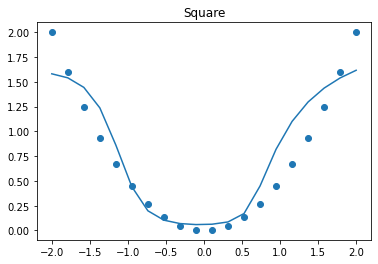

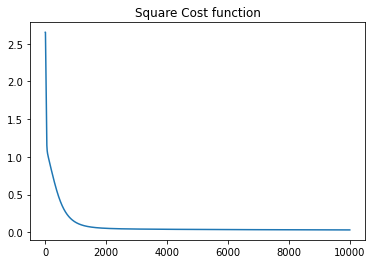

600 0.6859258568462386
1200 0.6548041103487119
1800 0.6432184558606595
2400 0.635503993079081
3000 0.6297870137895927
3600 0.6252916582648168
4200 0.6215816711972862
4800 0.6183907197608574
5400 0.6155398613106431
6000 0.6128912200180892
6600 0.6103213634565602
7200 0.6077040493916473
7800 0.6047645861225702
8400 0.6006110045144926
9000 0.5950959235907693
9600 0.5896146358915637


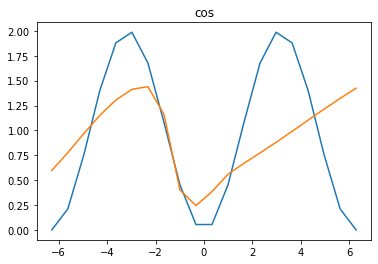

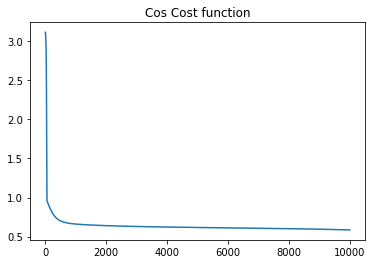

In [84]:

def sqr_test():
    b = generate_synthetic_batches(I,"1sqr")
    Y = b["Y"]

    c, inv = scale(b["c"])

    d_0 = Y.shape[0]
    d = d_0*2

    th = initialize_weights(d_0, d, K)
    JJ, th = train(c, d, d_0, K, h, Y, th, tau, max_it, method="gd")
    
    x = np.linspace(-2, 2, I)
    x = np.reshape(x,(1,len(x)))
    y = 1/2 *x**2
    
    z, yhat = F_tilde(x, th, d_0, d, K, h)
    yhat = inv(yhat)
    yhat = yhat.T

    plt.title("Square")
    plt.scatter(x.T,y.T)
    plt.plot(x.T,yhat.T)
    plt.show()
    
    plt.title("Square Cost function")
    plt.plot(JJ)
    plt.show()


def cos_test():
    high = 2*np.pi
    low = -2*np.pi
    b = generate_synthetic_batches(I,"1cos", low, high)

    Y = b["Y"]
    c, inv = scale(b["c"])

    d_0 = Y.shape[0]
    d = d_0*2

    th = initialize_weights(d_0, d, K)
    JJ, th = train(c, d, d_0, K, h, Y, th, tau, max_it, method="gd")
    
    x = np.linspace(low, high, I)
    x = np.reshape(x,(1,len(x)))
    y = 1 - np.cos(x)
    
    z, yhat = F_tilde(x, th, d_0, d, K, h)
    yhat = inv(yhat)
    yhat = yhat.T

    plt.title("cos")
    plt.plot(x.T,y.T, label="Neural Net")
    plt.plot(x.T,yhat.T, label="Training Data")
    plt.show()
    
    plt.title("Cos Cost function")

    plt.plot(JJ)
    plt.show()

K = 20
h = 0.1
I = 20
tau = 0.01
max_it = 10000

sqr_test() 
cos_test()   

(b) Investigate systematically what are optimal choices for K, τ , d, h and any
other choices you need to make. Balance performance in the generalisation
phase with time consumption of training

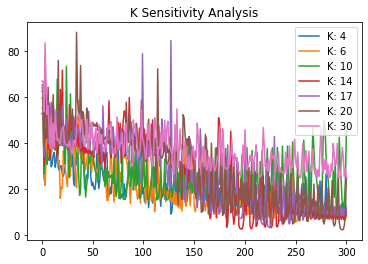

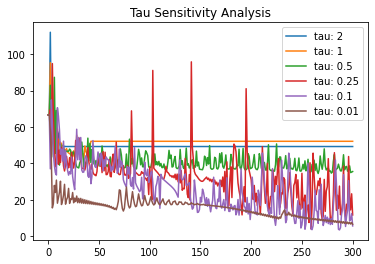

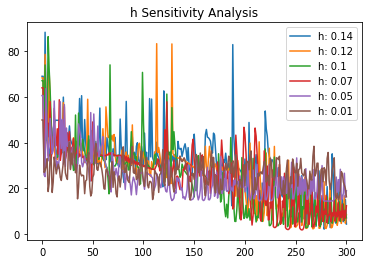

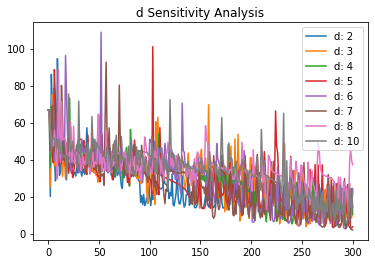

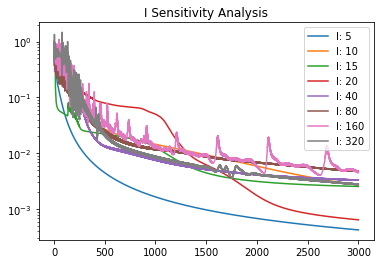

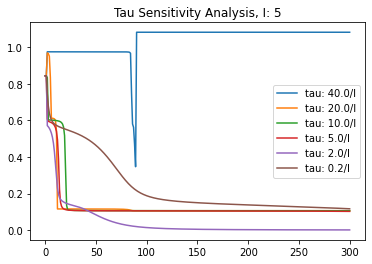

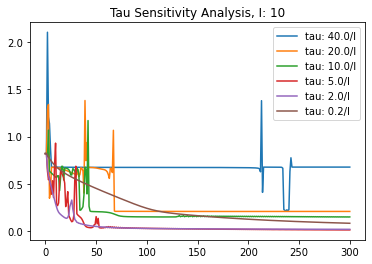

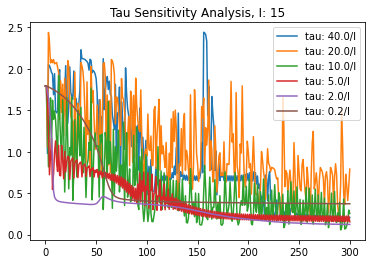

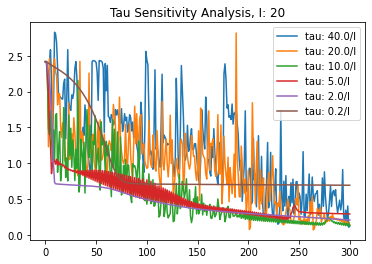

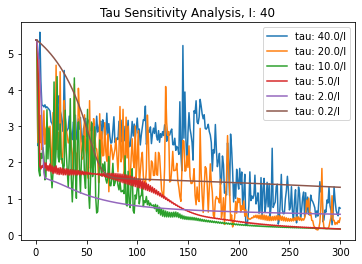

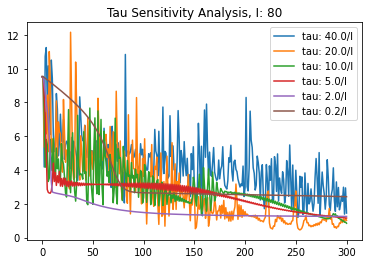

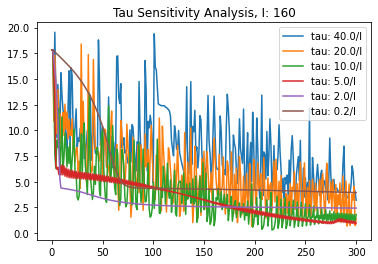

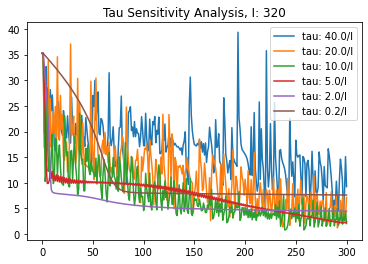

In [76]:
#@title Sensitivity Analsysis



def tau_sensitivity():
                
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = [ 2, 1, 0.5, 0.25, 0.1, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="tau: "+ str(tau))
    
    plt.title("Tau Sensitivity Analysis")
    plt.legend()
    plt.show()
    
def tauI_sensitivity(I):
                
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = np.array([ 40, 20, 10, 5, 2, 0.2])/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="tau: "+ str(tau*I) + "/I")
    
    plt.title("Tau Sensitivity Analysis, I: "+str(I))
    plt.legend()
    plt.show()
    
def I_selection():       
    var = [5, 10, 15, 20, 40, 80, 160, 320]
    for I in var:
        tauI_sensitivity(I)
    

def K_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 4, 6, 10, 14, 17, 20, 30]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        K = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="K: "+ str(var[i]))
    
    plt.title("K Sensitivity Analysis")
    plt.legend()
    plt.show()

    

def h_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 0.14, 0.12, 0.1, 0.07, 0.05, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        h = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="h: "+ str(var[i]))
    
    plt.title("h Sensitivity Analysis")
    plt.legend()
    plt.show()


def d_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 2, 3, 4, 5,6,7,8, 10 ]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        d = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="d: "+ str(var[i]))
    
    plt.title("d Sensitivity Analysis")
    plt.legend()
    plt.show()

def I_sensitivity():
    max_it = 3000             
    var = var = [5, 10, 15, 20, 40, 80, 160, 320]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        I = var[i]
        b = generate_synthetic_batches(I)
        c, inv = scale(b["c"])
        Y = b["Y"]
        #Y = scale(b["Y"])
        d_0 = Y.shape[0]
    
     #   print("I:", I)
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, print_it=False, method="gd")
        JJ = JJ/JJ[0]
        plt.plot(it, JJ, label="I: "+ str(var[i]))
    
    #plt.yscale("log")
    plt.title("I Sensitivity Analysis")
    plt.yscale("log")
    plt.legend()
    plt.show()    
    



# Default values based on the analysis
K = 20
h = 0.1
d_0 = 2
d = 4
I = 600
max_it = 300
tau = 0.1


K_sensitivity()
tau_sensitivity()
h_sensitivity()
d_sensitivity()
I_sensitivity()
I_selection()

(c) Train the model for the case of data given (with unknown Hamiltonian func-
tion).

In [ ]:

def train_uknown():
    K = 20
    h = 0.1
    I = 80
    max_it = 1
    sifts = 110
    tau = 0.1
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 40
    testbatch = batches[antB-1]
    
    
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    
    th = initialize_weights(d_0, d, K)
    JJ = np.array([])
    
    
    bigbatch = {}
    bigbatch["Y"] = np.array([[],[],[]])
    bigbatch["c"] = np.array([])
    
    for i in range(antB):
        batch = batches[i]
        bigbatch["Y"] = np.append(bigbatch["Y"],batch["Y_q"],1)
        bigbatch["c"] = np.append(bigbatch["c"],batch["c_q"])
        
    Y = bigbatch["Y"]
    c,inv = scale(bigbatch["c"][:,np.newaxis])
    
    JJ, th = stocgradient(c, d, d_0, K, h, Y, th, tau, 1 , 40, sifts)
 
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    tY = testbatch["Y_q"]
    tc,invscale = scale(testbatch["c_q"])
    
    z, yhat = F_tilde(tY, th, d_0, d, K, h)
    
    y = invscale(yhat)
    ic = invscale(tc)
    
    plt.plot(y)
    plt.plot(ic)
    plt.show()
    
    th_file = open("weights.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()

